In [1]:
library(tidyverse)

# Here we train our final model using the parameters from before.
grid_search_result <- read.csv("../outputs/B_outputs/B11_lgb_grid_kyoto3.csv")

best_logloss <- grid_search_result[which(grid_search_result$binary_logloss == min(grid_search_result$binary_logloss)), ]

best_auc <- grid_search_result[which(grid_search_result$auc == max(grid_search_result$auc)), ]

best_berror <- grid_search_result[which(grid_search_result$binary_error == min(grid_search_result$binary_error)), ]

best_params <- rbind(best_logloss, best_auc, best_berror)
best_params


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


,boostings,learning_rates,max_bins,num_leaves,max_depth,iteration,binary_logloss,auc,binary_error
,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
105,dart,0.10,25,15,10,187,0.347,0.917,0.153
35,dart,0.01,25,15,-1,996,0.351,0.922,0.152
63,dart,0.10,15,20,-1,57,0.367,0.905,0.151


In [2]:
# params
param_idx <- 1
boosting <- as.character(best_params[param_idx, "boostings"])
learning_rate <- as.numeric(best_params[param_idx, "learning_rate"])
max_bin <- as.numeric(best_params[param_idx, "max_bins"])
num_leaves <- as.numeric(best_params[param_idx, "num_leaves"])
max_depth <- as.numeric(best_params[param_idx, "max_depth"])

seed <- 42

# load data
train_val_set <- read.csv("../outputs/B_outputs/B11_japan_train_val.csv")
test_set <- read.csv("../outputs/B_outputs/B11_japan_test.csv")

feature_names <- c("tmax", "tmin", "prcp", "month", "day", "daily_Cd", "daily_Ca", "Cd_cumsum", "Ca_cumsum", "lat", "long", "alt")
target_col <- "is_bloom"

In [ ]:
library(lightgbm)

# num_boosting_rounds <- 2000L

    dtrain <- lgb.Dataset(
        data = data.matrix(train_val_set[, feature_names])
        , label = train_val_set[[target_col]]
        , params = list(
            min_data_in_bin = 1L
            , max_bin = max_bin
            )
    )

    dtest <- lgb.Dataset(
        data = data.matrix(test_set[, feature_names])
        , label = test_set[[target_col]]
        
    )
    

params <- list(
            objective = "binary"
            , metric = c("binary_logloss")
            , is_enable_sparse = TRUE
            , min_data_in_leaf = 2L
            , learning_rate = learning_rate
            , boosting = boosting
            , num_leaves = num_leaves
            , max_depth = max_depth
            
    )
valids <- list(test = dtest)
lgb_final <- lgb.train(params = params, data = dtrain, valids = valids, nrounds = 100L, verbose = 1)

saveRDS.lgb.Booster(lgb_final, file = "../outputs/B_outputs/B21_lgb_final.rds")

In [87]:
print(lgb_final$best_iter)
print(lgb_final$best_score)


<lgb.Booster>
  Public:
    add_valid: function (data, name) 
    best_iter: 39
    best_score: NA
    current_iter: function () 
    dump_model: function (num_iteration = NULL, feature_importance_type = 0L) 
    eval: function (data, name, feval = NULL) 
    eval_train: function (feval = NULL) 
    eval_valid: function (feval = NULL) 
    finalize: function () 
    initialize: function (params = list(), train_set = NULL, modelfile = NULL, 
    lower_bound: function () 
    params: list
    predict: function (data, start_iteration = NULL, num_iteration = NULL, 
    raw: NA
    record_evals: list
    reset_parameter: function (params, ...) 
    rollback_one_iter: function () 
    save: function () 
    save_model: function (filename, num_iteration = NULL, feature_importance_type = 0L) 
    save_model_to_string: function (num_iteration = NULL, feature_importance_type = 0L) 
    set_train_data_name: function (name) 
    to_predictor: function () 
    update: function (train_set = NULL, fo

In [13]:
# Run below codes after running the above
library(tidyverse)
library(lightgbm)
lgb_load <- readRDS.lgb.Booster('../outputs/B_outputs/B21_lgb_final.rds')

pred <- predict(lgb_load, as.matrix(test_set[, feature_names]))
test_set$predicted <- ifelse(pred > 0.5, 1, 0)

library(caret)
confusionMatrix(factor(test_set$predicted), factor(test_set$is_bloom))

Loading required package: R6


Attaching package: ‘lightgbm’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 51  7
         1  8 24
                                        
               Accuracy : 0.8333        
                 95% CI : (0.74, 0.9036)
    No Information Rate : 0.6556        
    P-Value [Acc > NIR] : 0.0001436     
                                        
                  Kappa : 0.6337        
                                        
 Mcnemar's Test P-Value : 1.0000000     
                                        
            Sensitivity : 0.8644        
            Specificity : 0.7742        
         Pos Pred Value : 0.8793        
         Neg Pred Value : 0.7500        
             Prevalence : 0.6556        
         Detection Rate : 0.5667        
   Detection Prevalence : 0.6444        
      Balanced Accuracy : 0.8193        
                                        
       'Positive' Class : 0             
                                        

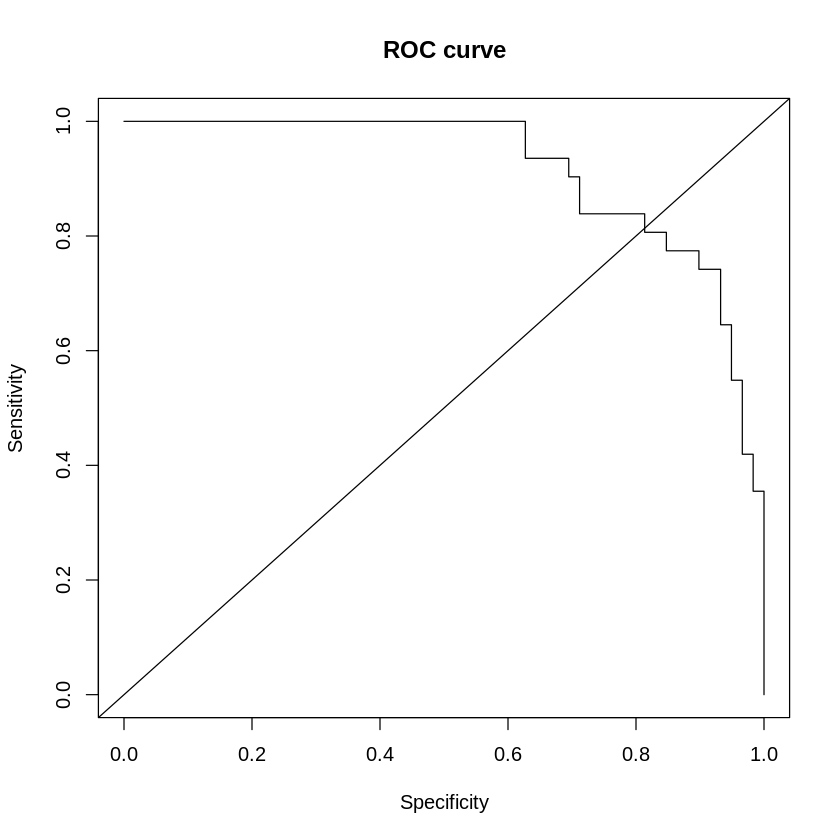

In [84]:
library(ROCR)
roc_pred <- prediction(pred, test_set$is_bloom)
roc <- performance(roc_pred, "sens", "spec")
plot(roc, main="ROC curve")
abline(a=0, b=1)

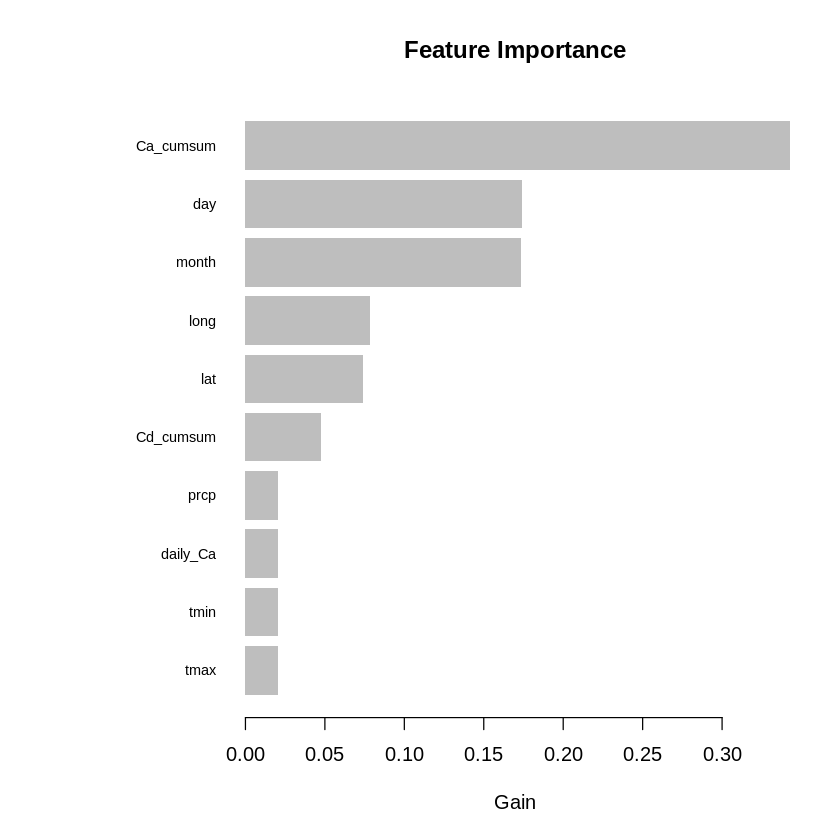

In [85]:
lgb_imp <- lgb.importance(lgb_load, percentage = TRUE)
lgb.plot.importance(lgb_imp, top_n = 10L, measure = "Gain")

In [86]:
# lgb.save(booster = lgb_final, filename = "../B_outputs/B21_lgb_final2.txt", num_iteration = NULL)
# aa <- lgb.load(filename = "../B_outputs/B21_lgb_final2.rds")
# pred2 <- predict(aa, as.matrix(test_set[, feature_names]))
# pred2

In [6]:
gdd_data <- read.csv("../outputs/A_outputs/A41_gdd_kyoto.csv") %>%
    filter(year %in% 2012:2023)
dim(gdd_data)



[1] 6002   20

In [20]:
aa <- gdd_data[gdd_data$is_bloom, ]
unique(aa$name)

[1] "HAMADA"

In [19]:
# for one year

yr = 2020
year_data <- gdd_data %>% filter(year == yr & name == "KYOTO")
head(year_data[year_data$is_bloom == 1, ])
dim(year_data)

# Make prediction on this data
# feature_names <- c("tmax", "tmin", "prcp", "month", "day", "daily_Cd", "daily_Ca", "Cd_cumsum", "Ca_cumsum", "lat", "long", "alt")
# target_col <- "is_bloom"

# pred <- predict(lgb_load, as.matrix(year_data[, feature_names]))
# year_data$predicted <- ifelse(pred > 0.5, 1, 0)
# year_data[year_data$is_bloom == 1, ]


name,date,id,tmax,tmin,prcp,year,month,day,row_num,id_rownum,daily_Cd,daily_Ca,Cd_cumsum,Ca_cumsum,lat,long,alt,bloom_doy,is_bloom
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>


[1] 43 20